In [56]:
!pip install deep-translator





In [1]:

import torch
print(torch.cuda.is_available())

True


In [2]:
import pandas as pd
from translate import Translator
import random
from deep_translator import GoogleTranslator

In [3]:
with open("Downloads/google-10000-english-usa-no-swears-medium.txt", "r") as file:
    words = file.read().splitlines()

In [81]:
word_count = 1500
eng_words = words[:word_count]

In [82]:
type(words)

list

In [83]:
len(eng_words)

1500

In [84]:
languages ={"es":"Spanish","hi": "Hindi","or":"Oriya"}
translators = {lang:Translator(to_lang=lang) for lang in languages.keys()}

In [85]:
data ={"English":words}

In [86]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [87]:
filtered_words = []

for word in eng_words:
    doc = nlp(word)
    if not any(ent.text == word and ent.label_ in ['PERSON', 'GPE', 'ORG'] for ent in doc.ents):
        filtered_words.append(word)
print(f"Filtered list contains {len(filtered_words)} words after removing proper nouns.")

Filtered list contains 1407 words after removing proper nouns.


In [97]:
english_words = random.sample(filtered_words,1200)

In [ ]:
languages = ['es', 'fr', 'pt', 'hi', 'zh-CN']  
translations = {}
i = 0
for word in english_words:
    print(i)
    i+=1
    translations[word] = {}
    for lang in languages:
        translated_word = GoogleTranslator(source='en', target=lang).translate(word)
        translations[word][lang] = translated_word

In [100]:
translations_df = pd.DataFrame(translations).T

In [101]:
translations_df.reset_index(inplace=True)

In [102]:
translations_df.rename(columns={'index': 'en'}, inplace=True)

In [103]:
translations_df

,en,es,fr,pt,hi,zh-CN
0,listed,listado,répertorié,listado,सूचीबद्ध,上市
1,stats,Estadísticas,statistiques,estatísticas,आँकड़े,统计数据
2,ended,terminó,terminé,terminou,समाप्त,结束
3,label,etiqueta,étiquette,rótulo,लेबल,标签
4,effects,efectos,effets,efeitos,प्रभाव,效果
...,...,...,...,...,...,...
1195,exercise,ejercicio,exercice,exercício,व्यायाम,锻炼
1196,freedom,libertad,liberté,liberdade,स्वतंत्रता,自由
1197,entry,entrada,entrée,entrada,प्रवेश,入口
1198,accounts,cuentas,comptes,contas,हिसाब किताब,账户


In [3]:
translations_df.to_csv("multilingual_dataset_v2.csv")

NameError: name 'translations_df' is not defined

In [4]:
import tqdm as notebook_tqdm

In [3]:
from transformers import AutoModelForCausalLM,AutoTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

C:\Users\shash\anaconda3\envs\CUDATEST\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
checkpoints = [
    "bigscience/bloom-1.7b",
    "bigscience/bloom-1.7b-phase-1",
    "bigscience/bloom-1.7b-phase-2",
]
checkpoint = "bigscience/bloom-7b1"

In [5]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint)



To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading checkpoint shards: 100%|██████████| 2/2 [02:30<00:00, 75.33s/it]


In [6]:
tokenizer

BloomTokenizerFast(name_or_path='bigscience/bloom-7b1', vocab_size=250680, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [8]:
translations_df = pd.read_csv("multilingual_dataset.csv")

In [105]:
translations_df

,en,es,fr,pt,hi,zh-CN
0,listed,listado,répertorié,listado,सूचीबद्ध,上市
1,stats,Estadísticas,statistiques,estatísticas,आँकड़े,统计数据
2,ended,terminó,terminé,terminou,समाप्त,结束
3,label,etiqueta,étiquette,rótulo,लेबल,标签
4,effects,efectos,effets,efeitos,प्रभाव,效果
...,...,...,...,...,...,...
1195,exercise,ejercicio,exercice,exercício,व्यायाम,锻炼
1196,freedom,libertad,liberté,liberdade,स्वतंत्रता,自由
1197,entry,entrada,entrée,entrada,प्रवेश,入口
1198,accounts,cuentas,comptes,contas,हिसाब किताब,账户


In [38]:
def get_embedding(word):
    try:
        inputs = tokenizer(word, return_tensors="pt").input_ids
        if inputs is None or inputs.size(0) == 0:
            raise ValueError(f"Invalid tokenized input for word: {word}")
        inputs = inputs.to("cuda" if torch.cuda.is_available() else "cpu")
        with torch.no_grad():
            outputs = model.transformer.word_embeddings(inputs).mean(dim=1) 
        if outputs is None or outputs.size(0) == 0:
            raise ValueError(f"Invalid output embedding for word: {word}")
        return outputs.squeeze().cpu().numpy()
    except Exception as e:
        print(f"Error processing word '{word}': {str(e)}")
        return None

In [107]:
translations_df

,en,es,fr,pt,hi,zh-CN
0,listed,listado,répertorié,listado,सूचीबद्ध,上市
1,stats,Estadísticas,statistiques,estatísticas,आँकड़े,统计数据
2,ended,terminó,terminé,terminou,समाप्त,结束
3,label,etiqueta,étiquette,rótulo,लेबल,标签
4,effects,efectos,effets,efeitos,प्रभाव,效果
...,...,...,...,...,...,...
1195,exercise,ejercicio,exercice,exercício,व्यायाम,锻炼
1196,freedom,libertad,liberté,liberdade,स्वतंत्रता,自由
1197,entry,entrada,entrée,entrada,प्रवेश,入口
1198,accounts,cuentas,comptes,contas,हिसाब किताब,账户


In [108]:
embeddings = []
for _, row in translations_df.iterrows():
    word_embeddings = {
        'Word': row['en'],
        'embedding_en': get_embedding(row['en']),
        'embedding_es': get_embedding(row['es']),
        'embedding_fr': get_embedding(row['fr']),
        'embedding_pt': get_embedding(row['pt']),
        'embedding_hi': get_embedding(row['hi']),
        'embedding_zh': get_embedding(row['zh-CN'])
    }
    if all(embedding is not None for embedding in word_embeddings.values()):
        embeddings.append(word_embeddings)


In [109]:
embeddings_df = pd.DataFrame(embeddings)

In [110]:
embeddings_df

,Word,embedding_en,embedding_es,embedding_fr,embedding_pt,embedding_hi,embedding_zh
0,listed,"[0.0124053955, -0.020553589, -0.007259369, -0....","[-0.012273788, -0.0075950623, -0.009003639, -0...","[-0.0015501976, 0.0065345764, 0.00028508902, -...","[-0.012273788, -0.0075950623, -0.009003639, -0...","[-0.0056653023, -0.014911652, -0.0016055107, -...","[-0.014892578, 0.016342163, 0.006164551, -0.00..."
1,stats,"[-0.01687622, -0.0047721863, 0.0008020401, -7....","[0.0077387495, 0.006450653, -0.0035832725, 0.0...","[-0.008366883, -0.0042591095, -0.0029344559, -...","[-0.0042037964, -0.0024032593, -0.0031318665, ...","[0.012176832, -0.0072313948, 0.0059369407, -0....","[0.015853882, -0.005924225, 0.0030708313, 0.00..."
2,ended,"[-0.013206482, 0.018295288, -0.006324768, 0.00...","[-0.0026659966, 0.0061473846, 4.9591064e-05, 0...","[-0.014001846, 0.0011463165, -0.0038909912, 0....","[0.0017757416, 0.0018634796, -0.0033435822, 0....","[0.0025450587, -0.00050735474, -0.0019073486, ...","[-0.0052452087, 0.005428314, -0.0034046173, 0...."
3,label,"[0.0075302124, 0.022094727, 0.00036668777, 0.0...","[0.0025253296, -0.0026721954, 0.00709486, 0.01...","[-0.0030140877, 0.006439209, 0.008716583, 0.02...","[0.014038086, 0.008991639, 0.011574428, 0.0057...","[-0.0024194717, -0.013786316, 0.0063443184, 0....","[-0.008102417, -0.000500679, 0.003276825, -0.0..."
4,effects,"[-0.003288269, -0.00039291382, -0.008735657, 0...","[-0.0015745163, 0.0068674088, 0.008114338, 0.0...","[-0.01858902, -0.013703704, 0.0032577515, 0.01...","[0.0016694069, 0.012544632, 0.00014686584, -0....","[-0.0037670135, 0.00076675415, -0.0014489889, ...","[-0.021362305, -0.015357971, 0.003435135, 0.00..."
...,...,...,...,...,...,...,...
1195,exercise,"[0.006772995, 0.0024690628, -0.0026779175, -0....","[0.010811647, -0.0009086927, -0.002146403, -0....","[0.0069713593, -0.0036325455, 0.0020537376, 0....","[-0.0012569427, 0.0007702112, 0.004293442, 0.0...","[-0.00799942, -0.0029821396, 0.008876801, 0.00...","[0.004634857, 0.008926392, -0.0051956177, 0.00..."
1196,freedom,"[-0.00021266937, 0.0032839775, 0.006883621, 0....","[0.0026232402, 0.0060933433, 0.0071411133, 0.0...","[-0.00024795532, 0.008737564, 0.0077824593, -0...","[-0.0026988983, 0.010484695, 0.005458832, -0.0...","[-0.0054626465, -0.0045251846, -0.00034236908,...","[-0.0011711121, -0.0006942749, 0.003314972, 0...."
1197,entry,"[0.003047943, -0.007320404, -0.0008997917, -0....","[0.010978699, -0.00623703, 0.0054473877, -0.00...","[0.006252289, 0.005970001, 0.0068244934, -0.00...","[0.010978699, -0.00623703, 0.0054473877, -0.00...","[0.0074920654, -0.008658409, -0.003011942, -0....","[-0.0005970001, -0.0064926147, 0.009605408, -0..."
1198,accounts,"[-0.00042653084, 0.00080919266, -0.0067825317,...","[-0.009719133, 0.0026245117, 0.01266098, 0.002...","[-0.007827759, -0.0061950684, 0.0053901672, 0....","[-0.008072853, 0.012023926, 0.010501862, -0.01...","[0.0011386871, 0.006916404, 0.0023634434, 0.00...","[0.0019721985, -0.02218628, 0.0029792786, -0.0..."


In [111]:
embeddings_df.to_csv("multilingual_embeddings_v2.csv")

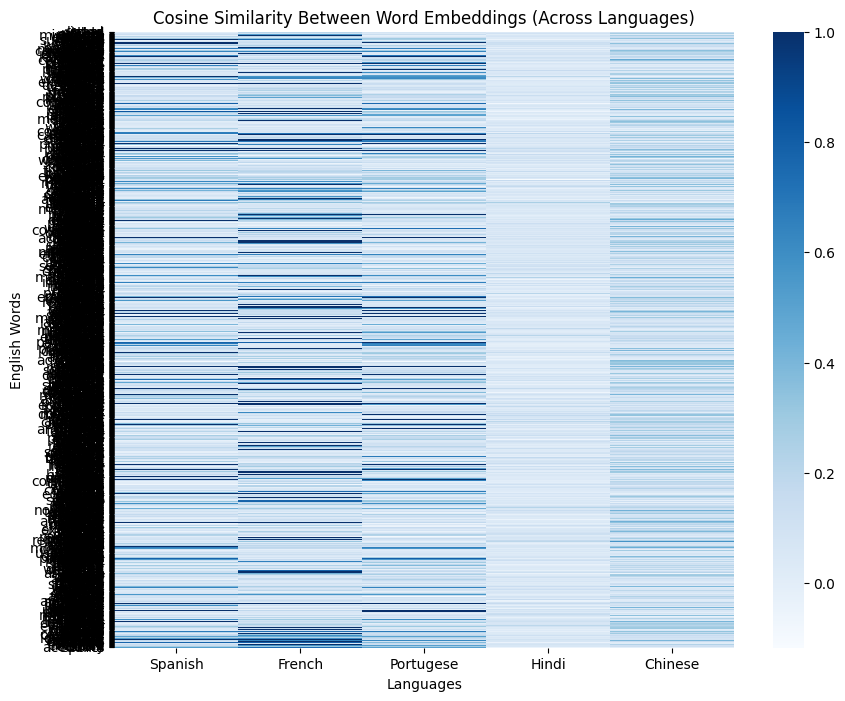

"sns.pairplot(similarity_df[['Similarity (ES-EN)', 'Similarity (HI-EN)', 'Similarity (OR-EN)']])\nplt.suptitle('Pairwise Similarity Between Embeddings (Across Languages)', y=1.02)\nplt.show()"

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
def compute_cosine_similarity(embeddings_df):
    similarities = []
    for _, row in embeddings_df.iterrows():
        embedding_en = row['embedding_en']
        embedding_es = row['embedding_es']
        embedding_fr = row['embedding_fr']
        embedding_pt = row['embedding_pt']
        embedding_hi = row['embedding_hi']
        embedding_zh = row['embedding_zh']
        similarity_es_en = cosine_similarity([embedding_en], [embedding_es])[0][0]
        similarity_fr_en = cosine_similarity([embedding_en], [embedding_fr])[0][0]
        similarity_pt_en = cosine_similarity([embedding_en], [embedding_pt])[0][0]
        similarity_hi_en = cosine_similarity([embedding_en], [embedding_hi])[0][0]
        similarity_zh_en = cosine_similarity([embedding_en], [embedding_zh])[0][0]
        similarities.append({
            'Word (English)': row['Word'],
            'Similarity (ES-EN)': similarity_es_en,
            'Similarity (FR-EN)': similarity_fr_en,
            'Similarity (PT-EN)': similarity_pt_en,
            'Similarity (HI-EN)': similarity_hi_en,
            'Similarity (ZH-EN)': similarity_zh_en
        })
    similarity_df = pd.DataFrame(similarities)
    return similarity_df
similarity_df = compute_cosine_similarity(embeddings_df)

def plot_similarity_heatmap(similarity_df):
    similarity_matrix = similarity_df[['Similarity (ES-EN)', 'Similarity (FR-EN)', 'Similarity (PT-EN)','Similarity (HI-EN)','Similarity (ZH-EN)']].values
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=False, cmap='Blues', xticklabels=['Spanish', 'French', 'Portugese','Hindi','Chinese'], yticklabels=similarity_df['Word (English)'], cbar=True)
    plt.title('Cosine Similarity Between Word Embeddings (Across Languages)')
    plt.xlabel('Languages')
    plt.ylabel('English Words')
    plt.show()
plot_similarity_heatmap(similarity_df)


In [147]:
similarity_df

,Word (English),Similarity (ES-EN),Similarity (FR-EN),Similarity (PT-EN),Similarity (HI-EN),Similarity (ZH-EN)
0,listed,0.207214,-0.019831,0.207214,0.135557,0.035313
1,stats,0.007705,0.214211,0.077216,0.036043,0.157139
2,ended,0.065772,0.055489,0.051000,0.015377,0.093861
3,label,0.079749,0.120752,0.043528,0.096904,0.267778
4,effects,0.306613,0.177858,0.263328,-0.018337,0.173405
...,...,...,...,...,...,...
1195,exercise,0.136304,0.564449,0.510602,0.057856,0.109641
1196,freedom,0.027927,0.069250,0.054921,0.091788,0.133920
1197,entry,0.281060,0.307308,0.281060,0.059346,0.125511
1198,accounts,0.030201,0.015271,-0.045552,0.021292,0.216996


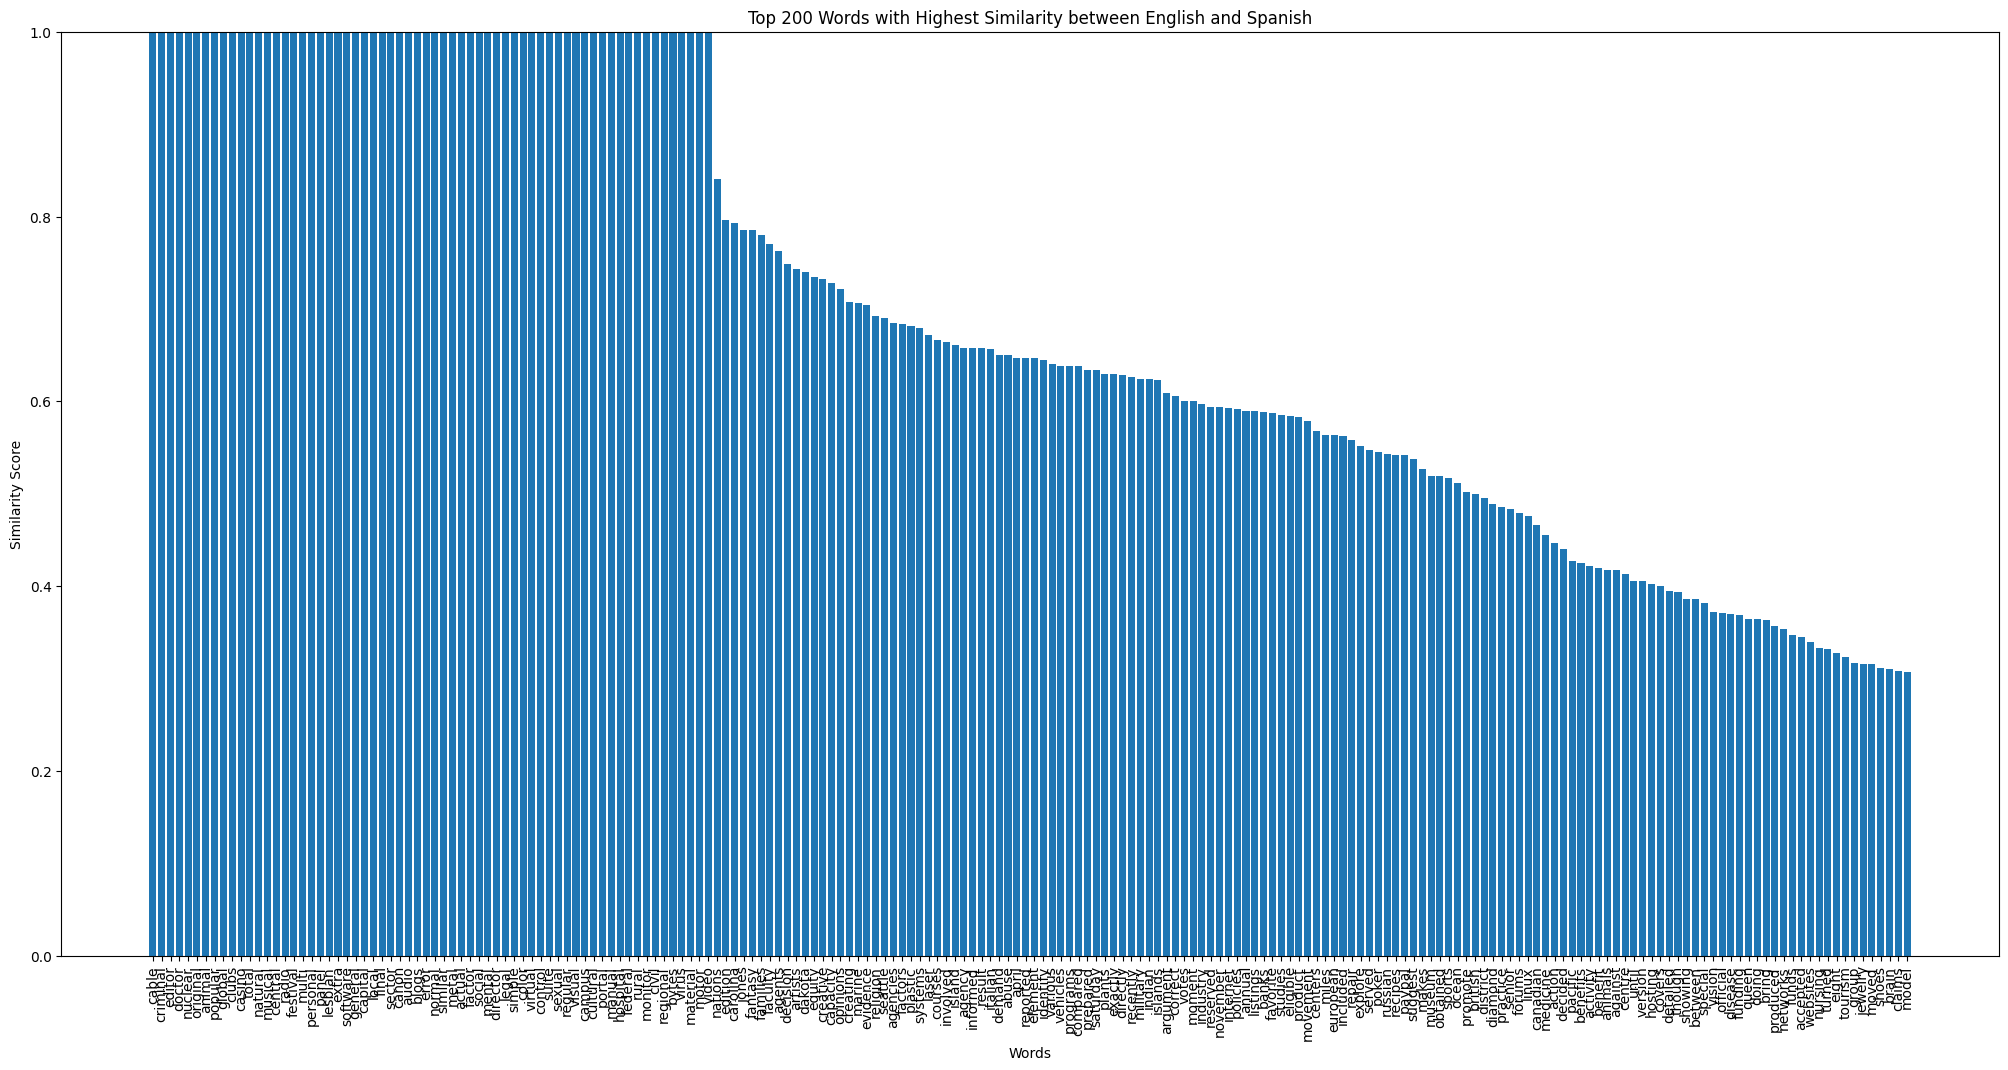

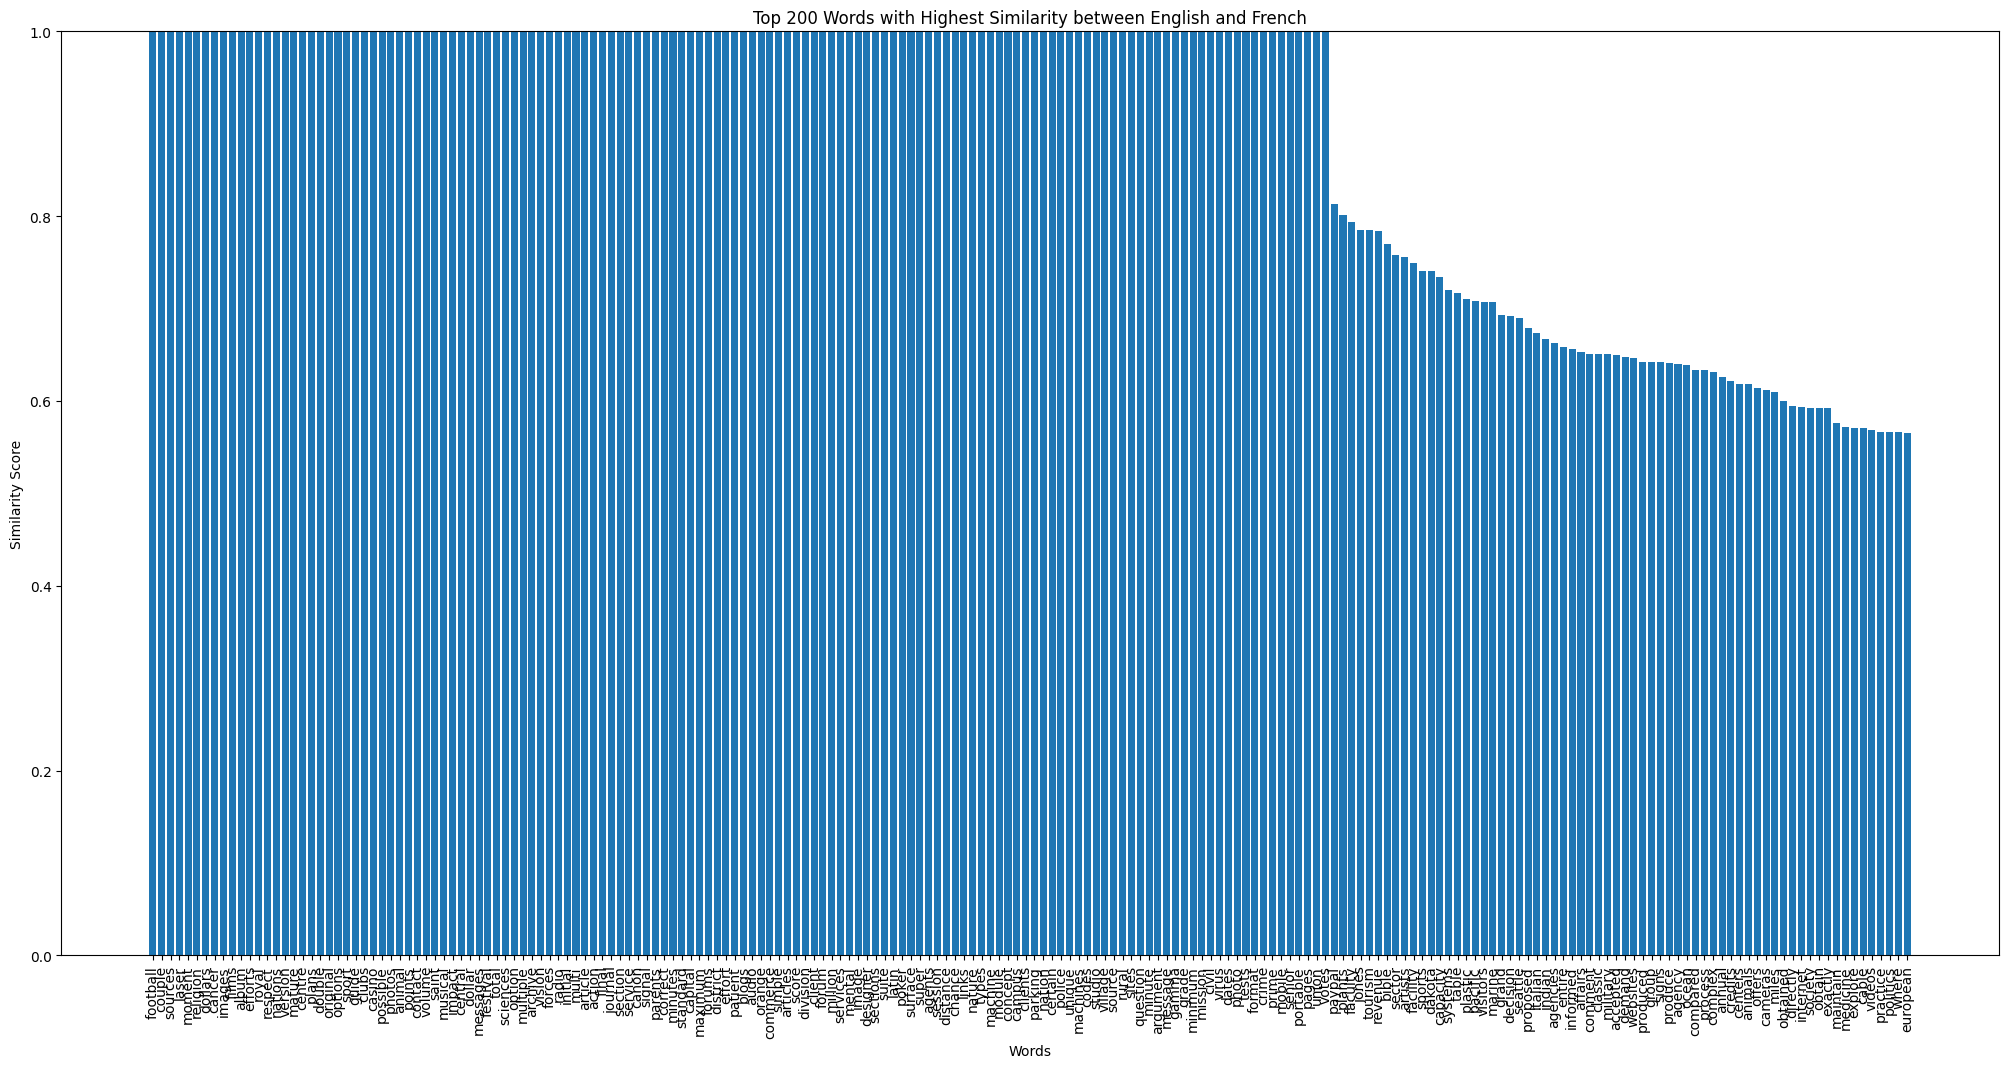

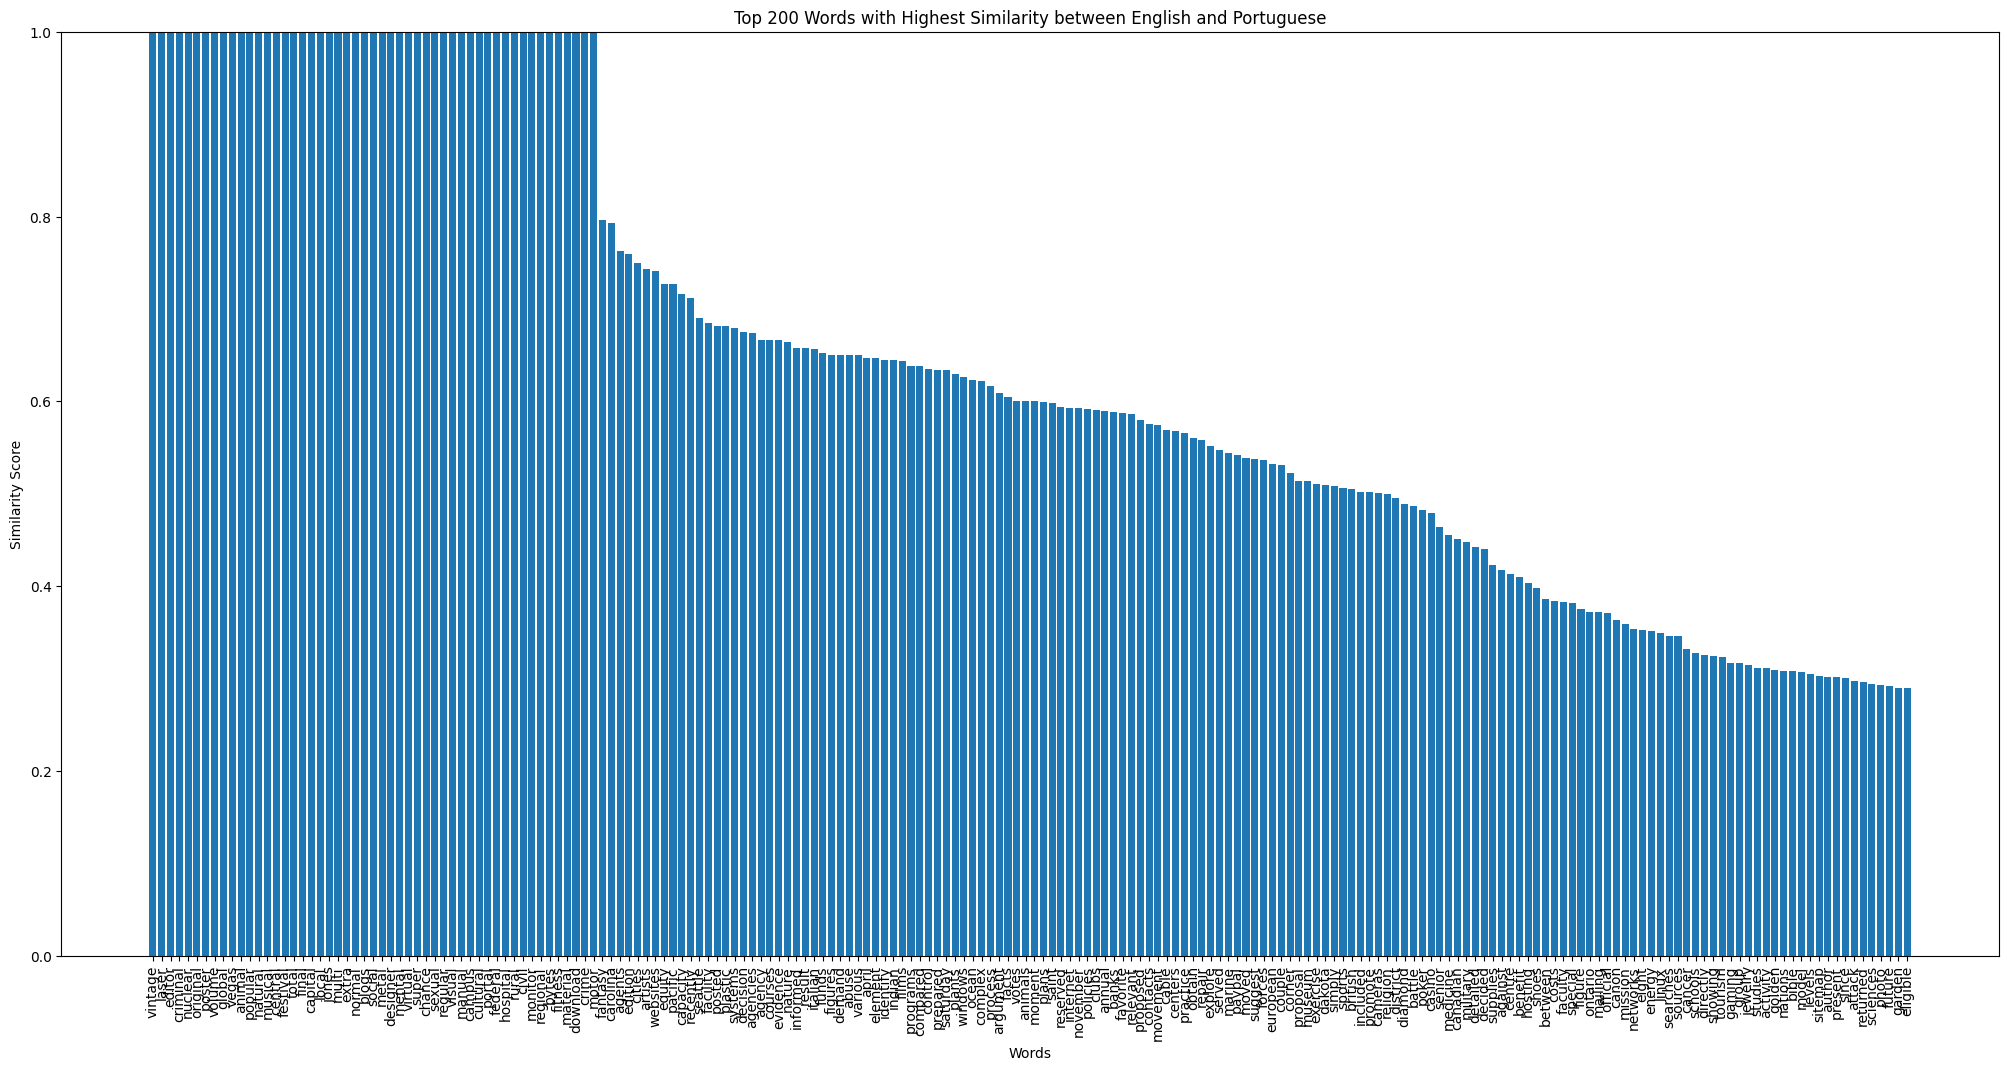

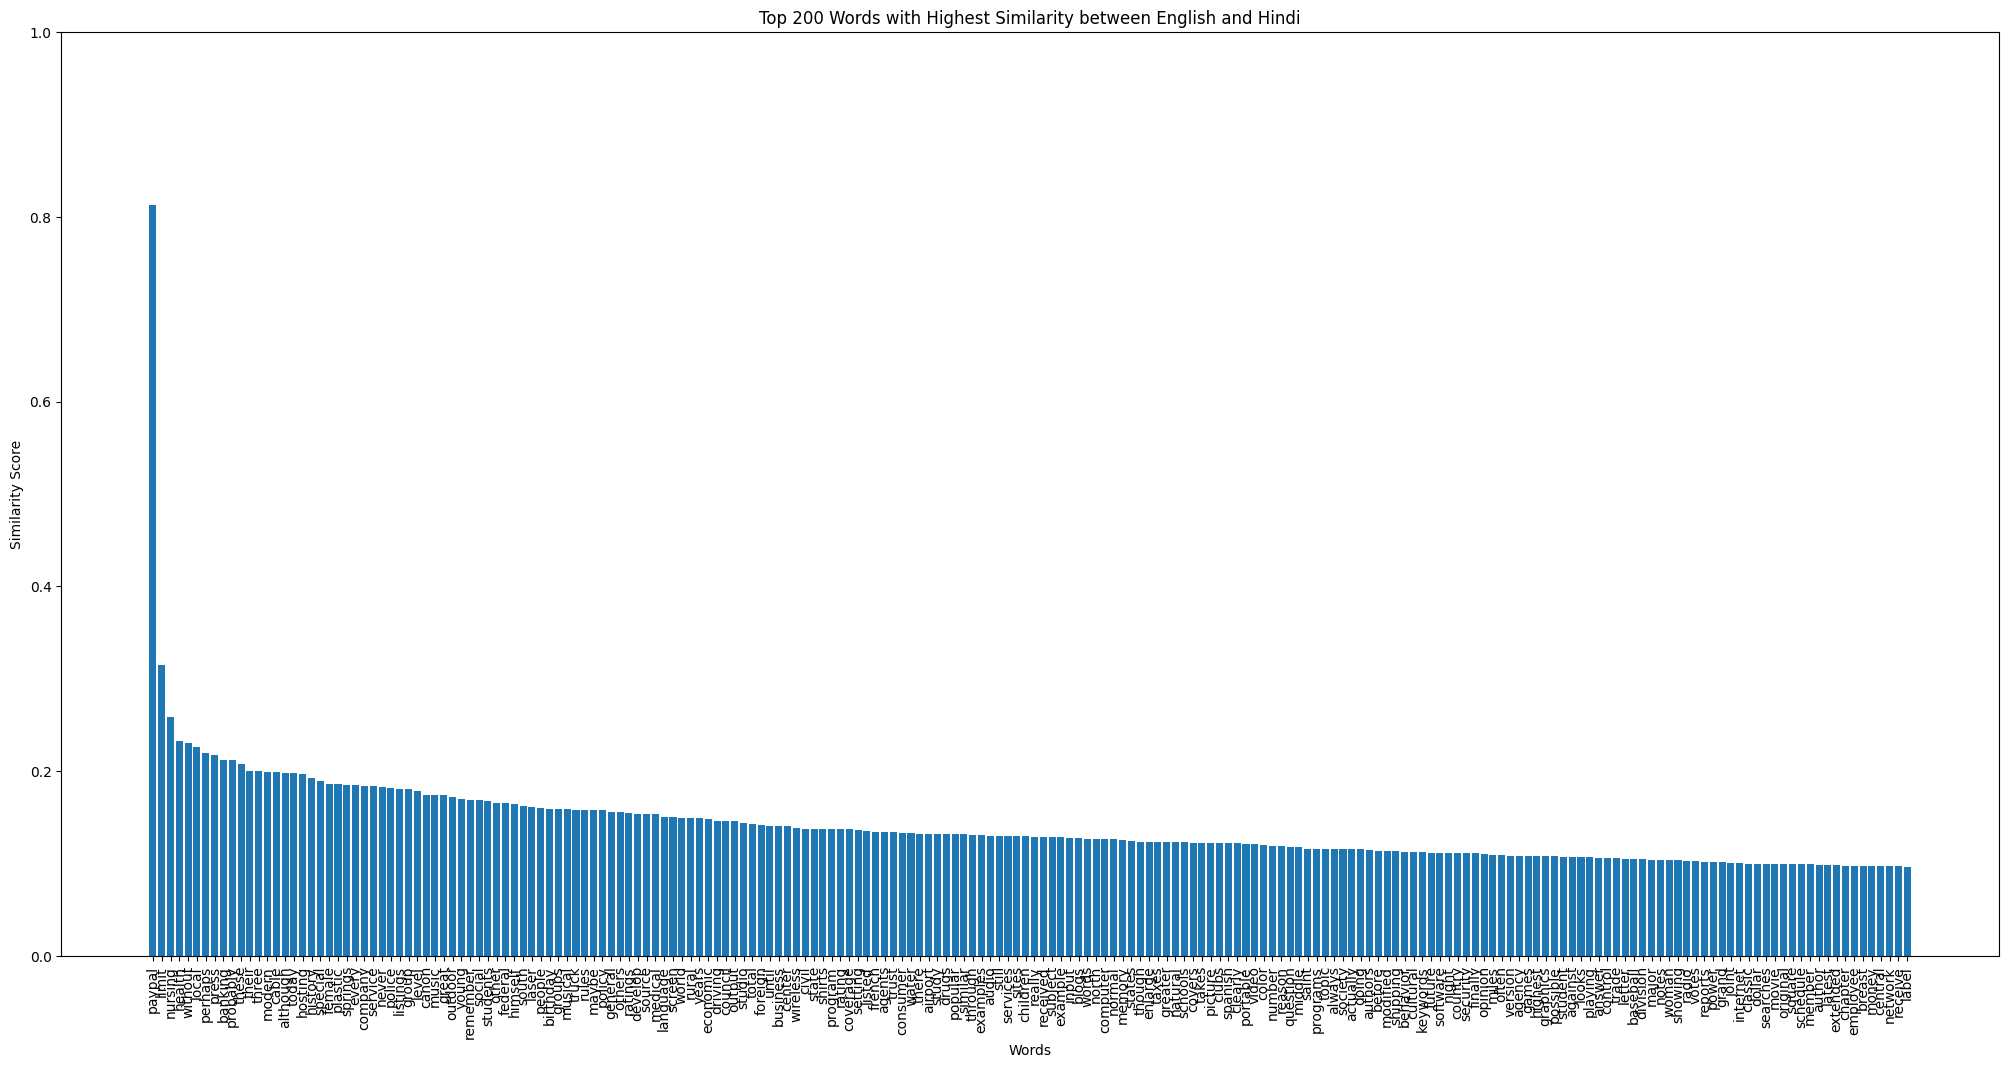

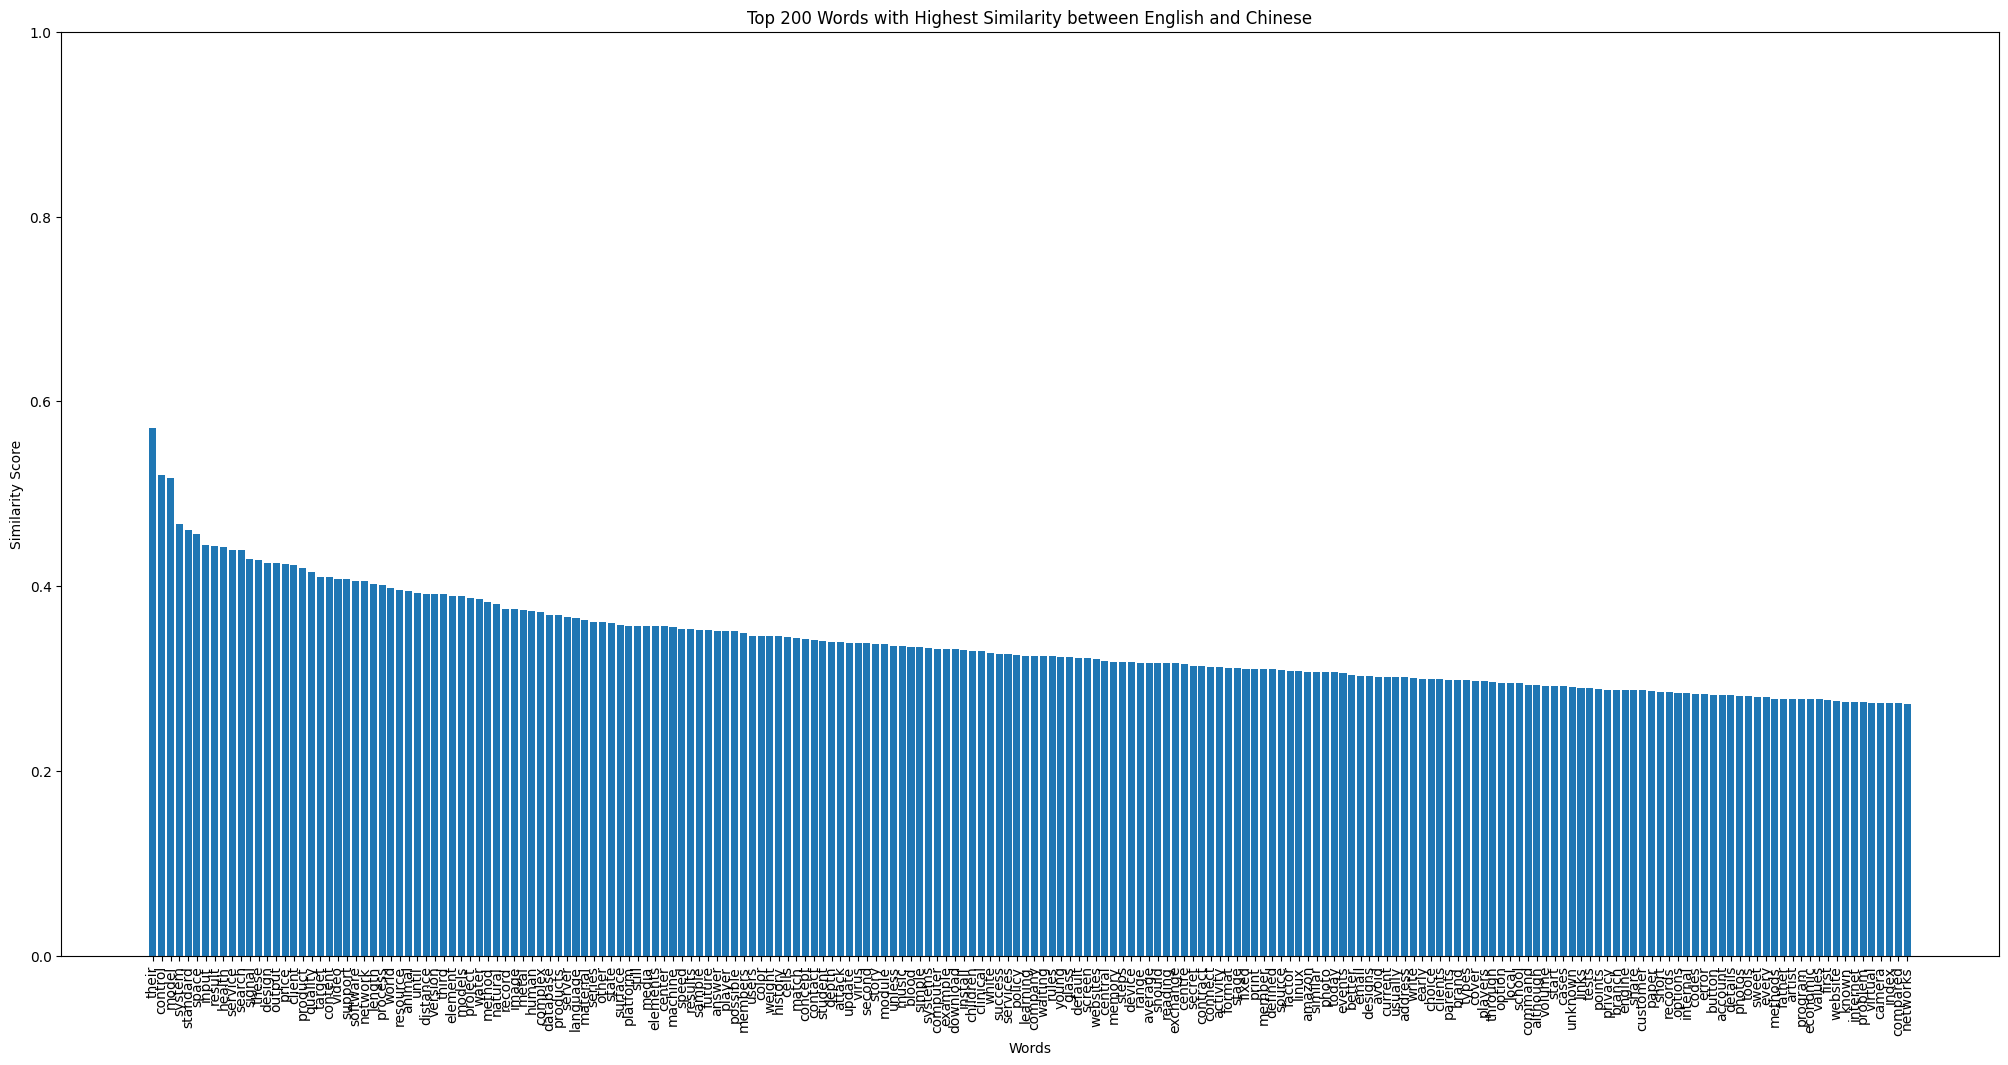

In [150]:

languages = {
    'Spanish': 'Similarity (ES-EN)',
    'French': 'Similarity (FR-EN)',
    'Portuguese': 'Similarity (PT-EN)',
    'Hindi': 'Similarity (HI-EN)',
    'Chinese': 'Similarity (ZH-EN)'
}

for lang, col in languages.items():
    try:
        sorted_df = similarity_df.sort_values(by=col, ascending=False)
        plt.figure(figsize=(25, 12))
        plt.bar(sorted_df['Word (English)'][:200], sorted_df[col][:200])
        plt.xticks(rotation=90)
        plt.xlabel('Words')
        plt.ylabel('Similarity Score')
        plt.title(f'Top 200 Words with Highest Similarity between English and {lang}')
        plt.ylim(0, 1)
        plt.show()
    except KeyError:
        print(f"Column {col} not found in the DataFrame. Skipping {lang}.")


In [151]:
!pip install datasets

  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
   ---------------------------------------- 0.0/25.1 MB ? eta -:--:--
   --- ------------------------------------ 2.1/25.1 MB 10.7 MB/s eta 0:00:03
   ----- ---------------------------------- 3.1/25.1 MB 8.4 MB/s eta 0:00:03
   ------ --------------------------------- 3.9/25.1 MB 6.5 MB/s eta 0:00:04
   -------- ------------------------------- 5.2/25.1 MB 6.2 MB/s eta 0:00:04
   ---------- ----------------------------- 6.8/25.1 MB 6.6 MB/s eta 0:00:03
   ------------ --------------------------- 7.9/25.1 MB 6.5 MB/s eta 0:00:03
   -------------- ------------------------- 9.2/25.1 MB 6.4 MB/s eta 0:00:03
   ---------------- ----------------------- 10.5/25.1 MB 6.3 MB/s eta 0:00:03
   ------------------ --------------------- 11.8/25.1 MB 6.4 MB/s eta 0:00:03
   -------------------- ------------------- 12.8/25.1 MB 6.2 MB/s eta 0:00:02
   ---------------------- ----------------- 14.2/25.1 MB 6.2 MB/s eta 0:00:02
   ---------

In [152]:
model

BloomForCausalLM(
  (transformer): BloomModel(
    (word_embeddings): Embedding(250880, 4096)
    (word_embeddings_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0-29): 30 x BloomBlock(
        (input_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (self_attention): BloomAttention(
          (query_key_value): Linear(in_features=4096, out_features=12288, bias=True)
          (dense): Linear(in_features=4096, out_features=4096, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (post_attention_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (mlp): BloomMLP(
          (dense_h_to_4h): Linear(in_features=4096, out_features=16384, bias=True)
          (gelu_impl): BloomGelu()
          (dense_4h_to_h): Linear(in_features=16384, out_features=4096, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
  )


In [4]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-1b7")
model = AutoModelForSequenceClassification.from_pretrained("bigscience/bloom-1b7", num_labels=3)

Some weights of BloomForSequenceClassification were not initialized from the model checkpoint at bigscience/bloom-1b7 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
for name, param in model.named_parameters():
    if "transformer.h" in name:  # Freeze transformer layers
        param.requires_grad = False


In [11]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")


transformer.word_embeddings.weight: requires_grad=True
transformer.word_embeddings_layernorm.weight: requires_grad=True
transformer.word_embeddings_layernorm.bias: requires_grad=True
transformer.h.0.input_layernorm.weight: requires_grad=False
transformer.h.0.input_layernorm.bias: requires_grad=False
transformer.h.0.self_attention.query_key_value.weight: requires_grad=False
transformer.h.0.self_attention.query_key_value.bias: requires_grad=False
transformer.h.0.self_attention.dense.weight: requires_grad=False
transformer.h.0.self_attention.dense.bias: requires_grad=False
transformer.h.0.post_attention_layernorm.weight: requires_grad=False
transformer.h.0.post_attention_layernorm.bias: requires_grad=False
transformer.h.0.mlp.dense_h_to_4h.weight: requires_grad=False
transformer.h.0.mlp.dense_h_to_4h.bias: requires_grad=False
transformer.h.0.mlp.dense_4h_to_h.weight: requires_grad=False
transformer.h.0.mlp.dense_4h_to_h.bias: requires_grad=False
transformer.h.1.input_layernorm.weight: req

In [12]:
from datasets import load_dataset

In [13]:
dataset_en = load_dataset("xnli", "en")


In [14]:
dataset_sw = load_dataset("xnli", "sw")

In [15]:
dataset_en

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 392702
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 5010
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 2490
    })
})

In [16]:
def tokenize_function(example):
    return tokenizer(
        text=example["premise"],
        text_pair=example["hypothesis"],
        truncation=True,
        padding="max_length",
        max_length=128,
    )


tokenized_train_en = dataset_en["train"].map(tokenize_function, batched=True)
tokenized_val_en = dataset_en["validation"].map(tokenize_function, batched=True)
tokenized_test_sw = dataset_sw["test"].map(tokenize_function, batched=True)

Map: 100%|██████████| 2490/2490 [00:00<00:00, 8427.51 examples/s]


In [17]:
tokenized_test_sw[99]

{'premise': 'Wakasema, Tunalipia mahali ambapo utakaa.',
 'hypothesis': 'Hawatalipia kitu chochote kwa niaba yetu.',
 'label': 2,
 'input_ids': [3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  58668,
  36421,
  15,
  62125,
  151383,
  387,
  145624,
  37395,
  166443,
  68,
  17,
  43,
  2895,
  2912,
  606,
  387,
  85487,
  191155,
  3865,
  98817,
  2825,
  88681,
  17],
 'attention_mask': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

In [18]:
tokenized_train_en = tokenized_train_en.remove_columns(["premise", "hypothesis"])
tokenized_val_en = tokenized_val_en.remove_columns(["premise", "hypothesis"])
tokenized_test_sw = tokenized_test_sw.remove_columns(["premise", "hypothesis"])

In [19]:
tokenized_train_en.set_format("torch")
tokenized_val_en.set_format("torch")
tokenized_test_sw.set_format("torch")

In [20]:
def compute_metrics(pred):
    predictions, labels = pred
    preds = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

In [28]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
)

In [32]:
from sklearn.metrics import accuracy_score, f1_score


In [29]:
training_args


TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_

In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_en,
    eval_dataset=tokenized_val_en,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

C:\Users\shash\AppData\Local\Temp\ipykernel_13464\387218542.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [31]:
trainer.train()


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 16.26 GiB is allocated by PyTorch, and 181.99 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
trainer.evaluate(tokenized_val_en)